> ## ⚠️ Important Lab Disclaimer
> This lab requires API keys (OpenAI, Tavily, OpenWeather) if you want to run the live examples.  
> These keys stay only inside the **temporary Udemy lab workspace** and are **not persisted or shared**, but you should still treat them like any other secret.  
> Use your own discretion when entering keys, and feel free to **revoke or rotate** them after the lab.  
> If you prefer **not** to use real API keys, Copy paste away or download the notebook and run it locally.


This script securely collect API key (`OPENAI_API_KEY`) using `getpass` so your input is hidden.  
It then creates/overwrites a `.env` file and writes each key as `NAME=value` on its own line.  
Finally, it prints **“Saved .env”** when finished.


In [ ]:
from getpass import getpass

names = ["OPENAI_API_KEY"]
with open(".env", "w", encoding="utf-8") as f:
    for n in names:
        f.write(f"{n}={getpass(f'Enter {n}: ').strip()}\n")
print("Saved .env")


This code locates the nearest `.env` file in the current working directory (using `find_dotenv`) and loads its key–value pairs into the environment (using `load_dotenv`).  
It does **not** overwrite any existing environment variables because `override=False`.


In [ ]:
from dotenv import load_dotenv, find_dotenv
env_path = find_dotenv(usecwd=True)
load_dotenv(env_path, override=False)

In [8]:
from typing import Dict, Any, List, Literal
from collections import Counter
import re
import json

from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, ToolMessage

from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition

from IPython.display import Image, display


In [2]:

chat = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

**Breakdown:**

- `@tool` wraps `calculator()` into a LangChain tool with one argument: `expression: str`.  
- The tool safely evaluates arithmetic using `eval` with builtins removed.  
- `chat.bind_tools([calculator])` tells the LLM it may call this tool.  
- `llm_with_tools.invoke("Calculate the expression: 3* 9 / 2 + 7 - 9")` sends the prompt + tool schema to the model.  


In [5]:

@tool
def calculator(expression: str) -> str:
    """Evaluate a simple arithmetic expression, e.g. '3 * 7' -> '21'."""
    try:
        return str(eval(expression, {"__builtins__": {}}, {}))
    except Exception as e:
        return f"error: {e}"
    
llm_with_tools = chat.bind_tools([calculator])

result = llm_with_tools.invoke("Calculate the expression: 3* 9 / 2 + 7 - 9")
result

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4vkqN54o4R4FlxrI6DKwtgkY', 'function': {'arguments': '{"expression": "3*9"}', 'name': 'calculator'}, 'type': 'function'}, {'id': 'call_HdilivpgLRGs3GsOpGuY7w7h', 'function': {'arguments': '{"expression": "2+7"}', 'name': 'calculator'}, 'type': 'function'}, {'id': 'call_iEK3EYI3kZDKLwlOaowIBsPv', 'function': {'arguments': '{"expression": "9"}', 'name': 'calculator'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 74, 'total_tokens': 135, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-ChhsCyvHUbZmICJdZ6kSL1IWFWPLQ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--51c5d021-f7b1-4a

- After the `.invoke(...)` completes, `result.tool_calls` shows **whether** the model attempted a tool call.  
- If the model called the tool, `result.tool_calls` contains a list 

> **Tool-Calling Disclaimer**
>
> LLM tool use is **non-deterministic**. The model may vary in:
> - how many tool calls it makes,
> - what arguments it sends,
> - and how it decomposes a task.
>
> This variation is normal. Your setup is correct as long as:
> - `result.tool_calls` contains valid tool calls, and  
> - the final `AIMessage` gives a reasonable answer.


In [6]:
result.tool_calls

[{'name': 'calculator',
  'args': {'expression': '3*9'},
  'id': 'call_4vkqN54o4R4FlxrI6DKwtgkY',
  'type': 'tool_call'},
 {'name': 'calculator',
  'args': {'expression': '2+7'},
  'id': 'call_HdilivpgLRGs3GsOpGuY7w7h',
  'type': 'tool_call'},
 {'name': 'calculator',
  'args': {'expression': '9'},
  'id': 'call_iEK3EYI3kZDKLwlOaowIBsPv',
  'type': 'tool_call'}]

**Breakdown:**

- The **same `calculator` tool** defined earlier is reused here; it safely evaluates arithmetic with builtins removed.
- `llm_with_tools = chat.bind_tools([calculator])` lets the LLM call that tool when needed.
- `tool_calling_llm(state)` runs the LLM on the incoming messages; the output may contain a tool call referencing **that same `calculator` function**.

**Graph flow:**
1. **START → tool_calling_llm**  
   LLM receives the user message and may request `calculator(expression=...)`.

2. **tools_condition**  
   Checks if the LLM actually emitted a tool call.

3. **tool_call → tools (ToolNode)**  
   Executes the *same* `calculator` tool function and returns its result.

4. **tools → END**  
   Graph ends after tool execution.

**Essential idea:**  
The graph auto-detects when the LLM wants to use the calculator and routes through the same tool function, executing it and returning its output.


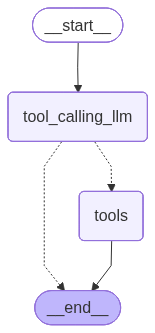

In [9]:

@tool
def calculator(expression: str) -> str:
    """Evaluate a simple arithmetic expression, e.g. '3 * 7' -> '21'."""
    try:
        return str(eval(expression, {"__builtins__": {}}, {}))
    except Exception as e:
        return f"error: {e}"
    
llm_with_tools = chat.bind_tools([calculator])
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([calculator]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",    
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

- Creates a `HumanMessage` asking: “What is 2 multiplied by 2 and then multiply the result by 16? Use the calculator.”
- Calls `graph.invoke({"messages": messages})`, which:
  - Runs the LLM node; the model is expected to call the existing `calculator` tool.
  - The `calculator` evaluates the implied expression (2 * 2 * 16) → **64**.
  - The final result (including “64”) is returned inside `out["messages"]`.


In [10]:
messages = [HumanMessage(content="What is 2 multiplied by 2 and then multipliy the result by 16? Use the calculator.")]
out = graph.invoke({"messages": messages})

In [11]:
out

{'messages': [HumanMessage(content='What is 2 multiplied by 2 and then multipliy the result by 16? Use the calculator.', additional_kwargs={}, response_metadata={}, id='2cab4734-be32-427d-a4a2-5b8389064faf'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XdQHGXmvIWeq5byREMqb1OCC', 'function': {'arguments': '{"expression": "2 * 2"}', 'name': 'calculator'}, 'type': 'function'}, {'id': 'call_PojPlttYaEB7FJ9TIbFi5A2q', 'function': {'arguments': '{"expression": "(2 * 2) * 16"}', 'name': 'calculator'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 79, 'total_tokens': 133, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-ChiCmLzbN5EOIHeL9kdgfQIzzcYkd', 'service_tier

- `out["messages"][1]` is the **AIMessage** created by `tool_calling_llm`.
- Accessing `.tool_calls` shows which tool the LLM asked to run and with what args, e.g.:
  - `[{"name": "calculator", "args": {"expression": "(2 * 2) * 16"}}]`
- If the model didn’t request any tool, this will be an empty list `[]`.


In [12]:
out["messages"][1].tool_calls

[{'name': 'calculator',
  'args': {'expression': '2 * 2'},
  'id': 'call_XdQHGXmvIWeq5byREMqb1OCC',
  'type': 'tool_call'},
 {'name': 'calculator',
  'args': {'expression': '(2 * 2) * 16'},
  'id': 'call_PojPlttYaEB7FJ9TIbFi5A2q',
  'type': 'tool_call'}]

- Previously, after a tool call, the graph went **tools → END** only.  
- Now there is an extra edge: **`builder.add_edge("tools", "tool_calling_llm")`**  
  - This creates a **loop**:  
    `tool_calling_llm → tools → tool_calling_llm` (and also → END).  
  - After `calculator` runs, the LLM gets **another turn** with the updated messages, so it can read the tool result (e.g., `64`) and generate a richer final answer instead of ending immediately after tool execution.


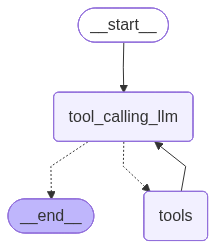

{'messages': [HumanMessage(content='What is 2 multiplied by 2 and then multipliy the result by 16? Use the calculator.', additional_kwargs={}, response_metadata={}, id='339dbcc0-94fa-423e-a90a-9d3fa2eea4d7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CyGDQOgXYffTsBUaDxRFclwz', 'function': {'arguments': '{"expression": "2 * 2"}', 'name': 'calculator'}, 'type': 'function'}, {'id': 'call_4Jihr6W9WVQ8yOiin72Vqud2', 'function': {'arguments': '{"expression": "(2 * 2) * 16"}', 'name': 'calculator'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 79, 'total_tokens': 133, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-ChiLrBWkeMEuGilBA2VpF7Sh87ug4', 'service_tier

In [13]:
@tool
def calculator(expression: str) -> str:
    """Evaluate a simple arithmetic expression, e.g. '3 * 7' -> '21'."""
    try:
        return str(eval(expression, {"__builtins__": {}}, {}))
    except Exception as e:
        return f"error: {e}"
    
llm_with_tools = chat.bind_tools([calculator])
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([calculator]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",    
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")  
builder.add_edge("tools", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

messages = [HumanMessage(content="What is 2 multiplied by 2 and then multipliy the result by 16? Use the calculator.")]
out = graph.invoke({"messages": messages})
out

**Breakdown:**

- The tool is now **`text_stats`**
  - It computes text analytics: `word_count`, `char_count`, `sentence_count`,
    `avg_word_len`, estimated read time, and `top_k_words` using a STOPWORDS list.
- `llm_with_tools = chat.bind_tools([text_stats])` lets the LLM call **this text-analysis tool**.
- The graph structure is similar (START → `tool_calling_llm` → conditional → `tools` → `tool_calling_llm` loop),  
  but now the loop is about:
  - LLM requesting `text_stats(text=..., top_k=..., strip_stopwords=...)`
  - Tool returning a **metrics dict**
  - LLM getting another turn to read those metrics and respond more intelligently.


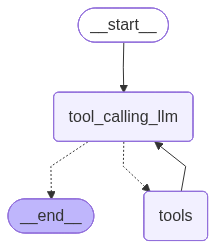

In [14]:
STOPWORDS = {
    "a","an","and","are","as","at","be","by","for","from","has","he","in","is",
    "it","its","of","on","that","the","to","was","were","will","with","this","you","your"
}

@tool
def text_stats(text: str, top_k: int = 5, strip_stopwords: bool = True) -> dict:
    """Return text metrics: word_count, char_count, sentence_count, avg_word_len,
    est_read_time_min (200 wpm), and top_k_words (frequency list)."""
    # basic cleanup
    chars = len(text)
    sentences = [s for s in re.split(r"[.!?]+", text) if s.strip()]
    tokens = re.findall(r"\b[\w']+\b", text.lower())
    words = [w for w in tokens if (not strip_stopwords or w not in STOPWORDS)]

    word_count = len(tokens)
    avg_word_len = (sum(len(w) for w in tokens) / word_count) if word_count else 0.0
    est_read_time_min = round(word_count / 200.0, 2)

    counter = Counter(words)
    top = counter.most_common(top_k)

    return {
        "word_count": word_count,
        "char_count": chars,
        "sentence_count": len(sentences),
        "avg_word_len": round(avg_word_len, 2),
        "est_read_time_min": est_read_time_min,
        "top_k_words": top,  # e.g. [["ai", 3], ["graph", 2], ...]
    }

llm_with_tools = chat.bind_tools([text_stats]) 
def tool_calling_llm(state: MessagesState):
    ai = llm_with_tools.invoke(state["messages"])
    return {"messages": [ai]}

builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([text_stats]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")  
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

- Defines `para` as a sample paragraph about LangGraph.  
- Builds a `HumanMessage` asking the LLM to **use the `text_stats` tool** on that paragraph and **summarize the results**.  
- `graph.invoke({"messages": msgs})` runs the graph:
  - LLM calls `text_stats(text=para, ...)`.
  - `text_stats` returns a metrics dict (word/char/sentence counts, avg word length, read time, top_k_words).
  - LLM gets another turn to read those metrics and produce a natural-language summary.  
- The `for m in out["messages"]: m.pretty_print()` loop prints the full trace.


In [15]:
para = """LangGraph helps build reliable LLM workflows. It adds state, tools, and control
flow so your agent doesn't wander. This paragraph should be long enough for stats."""
msgs = [HumanMessage(content=f"Use the text_stats tool on this paragraph and summarize the results:\n\n{para}")]
out = graph.invoke({"messages": msgs})

for m in out["messages"]:
    m.pretty_print()


================================ Human Message =================================

Use the text_stats tool on this paragraph and summarize the results:

LangGraph helps build reliable LLM workflows. It adds state, tools, and control
flow so your agent doesn't wander. This paragraph should be long enough for stats.
================================== Ai Message ==================================
Tool Calls:
  text_stats (call_LXPBCAwsAGYYDaj572Nts2kI)
 Call ID: call_LXPBCAwsAGYYDaj572Nts2kI
  Args:
    text: LangGraph helps build reliable LLM workflows. It adds state, tools, and control flow so your agent doesn't wander. This paragraph should be long enough for stats.
    top_k: 5
================================= Tool Message =================================
Name: text_stats

{"word_count": 26, "char_count": 162, "sentence_count": 3, "avg_word_len": 5.08, "est_read_time_min": 0.13, "top_k_words": [["langgraph", 1], ["helps", 1], ["build", 1], ["reliable", 1], ["llm", 1]]}
==============

**Breakdown:**

- Two **new tools** are introduced:  
  - `subwayDirections` (mock subway travel times)  
  - `attractionsNear` (mock attractions by category)  
- These tools are bound to the LLM via `llm_with_tools = ChatOpenAI(...).bind_tools(TOOLS)`.  
- The graph remains **single-stage**: `START → llm_turn → END`, with no routing or tool execution yet.  
- `llm_turn` simply lets the LLM decide whether to call `subwayDirections` or `attractionsNear`, and returns that AI message in state.  
- This graph demonstrates the **simplest staged setup**: a one-step LLM turn that *may* emit tool calls, but the graph does not execute them yet.
- **We will revisit the same ideas covered in the previous graphs—LLM turns, tool calls, and message flow—but now applied to this new, simplified staged graph.**


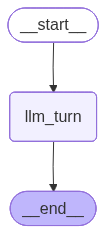

In [16]:
SUBWAY = {
    ("Times Sq-42 St", "Grand Central-42 St"): 5,
    ("Grand Central-42 St", "14 St-Union Sq"): 7,
}
POIS = [
    {"name":"Central Park","category":"park"},
    {"name":"Times Square","category":"landmark"},
    {"name":"The Met","category":"museum"},
    {"name":"MoMA","category":"museum"},
]

@tool
def subwayDirections(originStation: str, destinationStation: str) -> Dict[str, Any]:
    """Return rough subway minutes (mock numbers)."""
    minutes = SUBWAY.get((originStation, destinationStation),
              SUBWAY.get((destinationStation, originStation), 18))
    return {"originStation": originStation, "destinationStation": destinationStation, "minutes": minutes}

@tool
def attractionsNear(category: Literal["museum","park","landmark","any"] = "any", limit: int = 2) -> Dict[str, Any]:
    """Return a few NYC attractions by category (mock)."""
    items = [p for p in POIS if category == "any" or p["category"] == category][:limit]
    return {"category": category, "results": items}

TOOLS = [subwayDirections, attractionsNear]
llm_with_tools = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0).bind_tools(TOOLS)

def llm_turn(state: MessagesState):
    reply = llm_with_tools.invoke(state["messages"])  
    return {"messages": [reply]}

conv_graph = StateGraph(MessagesState)
conv_graph.add_node("llm_turn", llm_turn)
conv_graph.add_edge(START, "llm_turn")
conv_graph.add_edge("llm_turn", END)
conversation_agent = conv_graph.compile()
display(Image(conversation_agent.get_graph().draw_mermaid_png()))


- Sends a single user prompt instructing the LLM to get subway minutes *and* list two museums.  
- `llm_with_tools.invoke([...])` runs one LLM turn that **may emit tool calls** for `subwayDirections` and `attractionsNear`.  
- The graph is not involved here—this is just a direct LLM-with-tools invocation.  
- **We are applying the same concepts as before (LLM deciding on tool calls, arguments, and ordering) but now on this staged setup outside the graph.**


In [17]:
prompt = (
    "You are a short NYC trip helper. "
    "First get subway minutes Times Sq-42 St -> Grand Central-42 St. "
    "Then list 2 museum attractions."
)
initial = llm_with_tools.invoke([("user", prompt)])

initial

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YDXKBEdua0NjVOJ3WcGXclFf', 'function': {'arguments': '{"originStation": "Times Sq-42 St", "destinationStation": "Grand Central-42 St"}', 'name': 'subwayDirections'}, 'type': 'function'}, {'id': 'call_w6VMSxoU8ZMicuLs1Ghx5ZmL', 'function': {'arguments': '{"category": "museum", "limit": 2}', 'name': 'attractionsNear'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 140, 'total_tokens': 204, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-ChilI1guag9JLhfHguNysdAHl93N5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--34f02891-d625-4abd-8390-859f780a20e7-0', tool_calls=[{'name': 'su

In [18]:
initial.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  subwayDirections (call_YDXKBEdua0NjVOJ3WcGXclFf)
 Call ID: call_YDXKBEdua0NjVOJ3WcGXclFf
  Args:
    originStation: Times Sq-42 St
    destinationStation: Grand Central-42 St
  attractionsNear (call_w6VMSxoU8ZMicuLs1Ghx5ZmL)
 Call ID: call_w6VMSxoU8ZMicuLs1Ghx5ZmL
  Args:
    category: museum
    limit: 2


In [19]:
initial.tool_calls

[{'name': 'subwayDirections',
  'args': {'originStation': 'Times Sq-42 St',
   'destinationStation': 'Grand Central-42 St'},
  'id': 'call_YDXKBEdua0NjVOJ3WcGXclFf',
  'type': 'tool_call'},
 {'name': 'attractionsNear',
  'args': {'category': 'museum', 'limit': 2},
  'id': 'call_w6VMSxoU8ZMicuLs1Ghx5ZmL',
  'type': 'tool_call'}]

- Runs the staged graph (`conversation_agent`) instead of the raw LLM.  
- The graph performs one LLM turn (`llm_turn`) using the same tools and returns the final AI message.  
- Same idea as before—tool-enabled LLM behavior—but now executed through the graph.


In [20]:
aiMsg = conversation_agent.invoke({"messages": [("user", prompt)]})
aiMsg

{'messages': [HumanMessage(content='You are a short NYC trip helper. First get subway minutes Times Sq-42 St -> Grand Central-42 St. Then list 2 museum attractions.', additional_kwargs={}, response_metadata={}, id='01429f93-eaaa-4155-8d43-8dda7d149da1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eJvI8uAwe7T1YTpEmXWJpaMh', 'function': {'arguments': '{"originStation": "Times Sq-42 St", "destinationStation": "Grand Central-42 St"}', 'name': 'subwayDirections'}, 'type': 'function'}, {'id': 'call_6Vi3Lp6SBTK2HDSRluzZJNrr', 'function': {'arguments': '{"category": "museum", "limit": 2}', 'name': 'attractionsNear'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 140, 'total_tokens': 204, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model

- Builds a **looping LLM-tool graph**: `assistant → tools → assistant`.  
- The LLM can call either travel tool, the tool executes, and the updated messages feed back into another LLM turn.  
- Same core idea as before—LLM + tool calls—but now with a **continuous interaction loop** instead of a single turn.


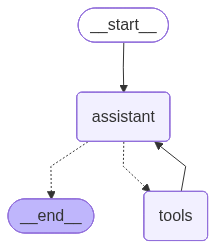

In [21]:


def assistant_node(state: MessagesState):
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}  

agent_graph = StateGraph(MessagesState)
agent_graph.add_node("assistant", assistant_node)
agent_graph.add_node("tools", ToolNode(TOOLS))

agent_graph.add_edge(START, "assistant")

agent_graph.add_conditional_edges("assistant", tools_condition, )
agent_graph.add_edge("tools", "assistant") 

travel_agent = agent_graph.compile()

display(Image(travel_agent.get_graph().draw_mermaid_png()))

In [22]:
aiMsg = travel_agent.invoke({"messages": [("user", prompt)]})

In [23]:
aiMsg

{'messages': [HumanMessage(content='You are a short NYC trip helper. First get subway minutes Times Sq-42 St -> Grand Central-42 St. Then list 2 museum attractions.', additional_kwargs={}, response_metadata={}, id='6d0bf6e7-1d22-415a-a234-7e9ca49da0a6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Jwh8NptvTeGPA9wENd4XdccY', 'function': {'arguments': '{"originStation": "Times Sq-42 St", "destinationStation": "Grand Central-42 St"}', 'name': 'subwayDirections'}, 'type': 'function'}, {'id': 'call_dtDsbanvaKzngqEibZYvVAH6', 'function': {'arguments': '{"category": "museum", "limit": 2}', 'name': 'attractionsNear'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 140, 'total_tokens': 204, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model